# BINOSNP DATA ANALYSIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multicomp as mc
from scipy import stats
import pickle
from scipy.stats import mannwhitneyu as mannwu
from matplotlib.ticker import MultipleLocator

import sys
sys.path.append("./scripts/modules")

from benchmarking_definitions import *
from plotting import *

In [2]:
tags = pd.read_csv("./data/binosnp_data_analysis/binosnp_data_tags.csv", names=["tag"]).tag.values
len(tags)

6

In [3]:
freqs = [1, 5, 10]

In [4]:
source_dir = "/n/scratch/users/s/sm624/benchmarking/variant_summaries/binosnp_data"

In [5]:
blue = "#1E90FF"

In [6]:
rpob_precision_recall_df = pd.read_csv("./data/binosnp_data_analysis/rpob_precision_recall.csv")
rpob_precision_recall_df.head()

,tag,Rpob_mutation,freq,num_FP,precision,recall,tool
0,Mix-SR1a-rpoB531-1,SR1a,0.01,2.0,0.333333,1.0,FreeBayes
1,Mix-SR1a-rpoB531-1,SR1a,0.01,0.0,0.000000,0.0,LoFreq
2,Mix-SR1a-rpoB531-1,SR1a,0.01,0.0,0.000000,0.0,Mutect2
3,Mix-SR1a-rpoB531-1,SR1a,0.01,100.0,0.009901,1.0,Pilon
4,Mix-SR1a-rpoB531-1,SR1a,0.01,0.0,0.000000,0.0,VarDict


In [44]:
rpoB_FP_AF = pd.read_csv("./data/binosnp_data_analysis/rpoB_FP_AF.csv")

In [8]:
rpob_precision_recall_over5_df = pd.read_csv("./data/binosnp_data_analysis/rpob_precision_recall_overAF5.csv")
rpob_precision_recall_over5_df.head()

,tag,Rpob_mutation,freq,num_FP,precision,recall,tool
0,Mix-SR1a-rpoB531-1,SR1a,0.01,0.0,1.0,NaN,FreeBayes
1,Mix-SR1a-rpoB531-1,SR1a,0.01,0.0,0.0,NaN,LoFreq
2,Mix-SR1a-rpoB531-1,SR1a,0.01,0.0,0.0,NaN,Mutect2
3,Mix-SR1a-rpoB531-1,SR1a,0.01,0.0,1.0,NaN,Pilon
4,Mix-SR1a-rpoB531-1,SR1a,0.01,0.0,0.0,NaN,VarDict


In [9]:
DR_num_FP_df = pd.read_csv("./data/binosnp_data_analysis/DR_num_FP.csv")

In [10]:
DR_FP_AF = pd.read_csv("./data/binosnp_data_analysis/DR_FP_AF.csv")

In [11]:
DR_num_FP_over5_df = pd.read_csv("./data/binosnp_data_analysis/DR_num_FP_over5.csv")

In [12]:
DR_FP_AF_over5 = pd.read_csv("./data/binosnp_data_analysis/DR_FP_AF_over5.csv")

# [done] Depth distribution

In [13]:
tag_depths = {t:[] for t in tags}

for tag in tags:
    
    depth_file = f"/n/scratch/users/s/sm624/FP_characteristics/BSdata/bam_depths/{tag}.depth.tsv.gz"
    depth_df = pd.read_csv(depth_file, compression='gzip', sep='\t', header=None, names=['CHROM', 'POS', 'COV'])

    tag_depths[tag] = depth_df.COV.values


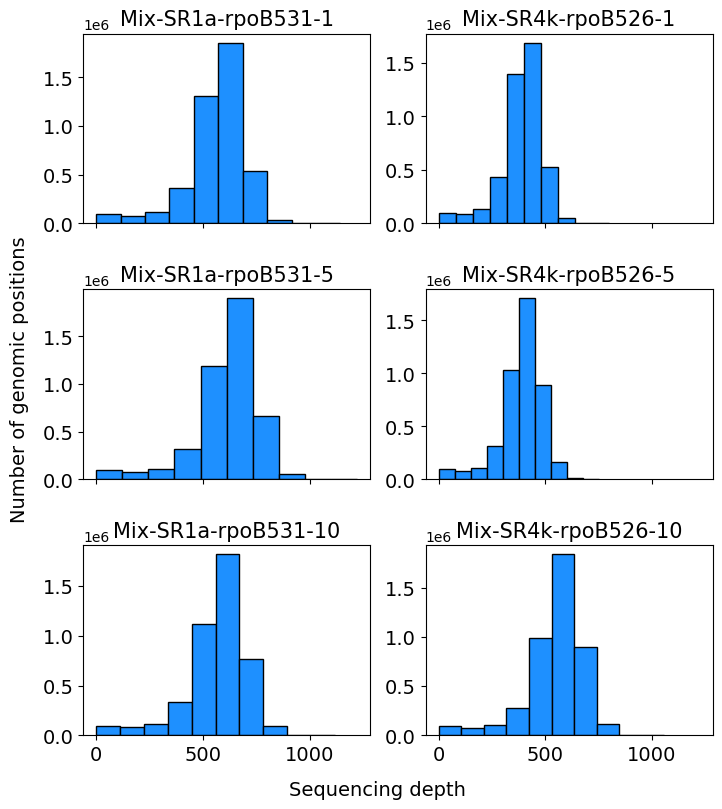

In [15]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(7, 8))

for tag_i in range(len(tags)):

    tag = tags[tag_i]

    ax_i, ax_j = tag_i//2, tag_i%2
    ax = axs[ax_i][ax_j]
    
    ax.set_title("{}".format(tag), fontsize=15)
    
    ax.tick_params(labelsize=14)
        
    ax.hist(tag_depths[tag], color=blue, edgecolor="black")
    
    ax.set_ylabel("")
    ax.set_xlabel("")
        
fig.text(0.5, -0.02, 'Sequencing depth', ha='center', fontsize=14)
fig.text(-0.025, 0.5, 'Number of genomic positions', va='center', rotation='vertical', fontsize=14)    
    
plt.tight_layout()

file_name = "./figures/binosnp_data_analysis/depth_distr.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/binosnp_data_analysis/depth_distr.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)    
    

plt.show()

# Recall

## Overall recall

In [13]:
for i in rpob_precision_recall_df.index:
    
    rpob_precision_recall_df.loc[i, "tag"] = rpob_precision_recall_df.loc[i, "tag"].split("-")[1]
    try:
        rpob_precision_recall_df.loc[i, "recall"] = int(rpob_precision_recall_df.loc[i, "recall"])
    except ValueError:
        continue

In [14]:
heatmap_dfs = {f: pd.DataFrame(columns=["tag", "tool", "value"]) for f in freqs}

for freq in freqs:
    heatmap_dfs[freq][["tag", "tool", "value"]] = rpob_precision_recall_df[rpob_precision_recall_df.freq == freq/100][["tag", "tool", "recall"]]


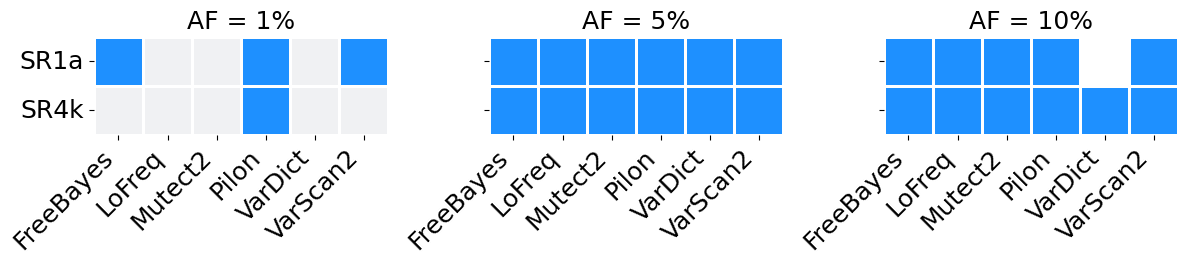

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

for freq_i in range(len(freqs)):
    
    freq = freqs[freq_i]
    
    df = heatmap_dfs[freq].pivot(index="tag", columns="tool", values="value")
    
    ax = axs[freq_i]

    ax.set_title("AF = {}%".format(freq), fontsize=18)
        
    sns.heatmap(data=df, square=True, vmin=0, vmax=1, cmap=sns.light_palette(blue), 
                linewidths=1, ax=ax, cbar=False)
    
    ax.tick_params(labelsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_linewidth(1.3)
    ax.spines['left'].set_linewidth(1.3)

    ax.tick_params(axis='x', labelrotation=45, labelsize=18) 
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontdict={"horizontalalignment": "right"})

    ax.tick_params(axis='y', labelrotation=0, labelsize=18)

    ax.set_xlabel("")
    ax.set_ylabel("")
    

plt.tight_layout()

file_name = "./figures/binosnp_data_analysis/rpob_recall_heatmap.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/binosnp_data_analysis/rpob_recall_heatmap.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

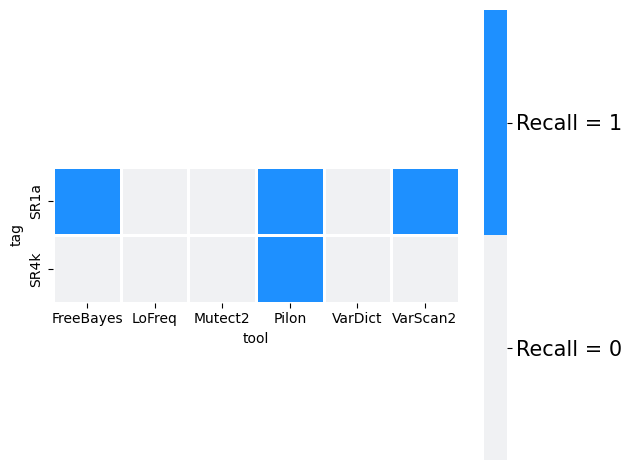

In [17]:
fig, ax = plt.subplots()

df = heatmap_dfs[1].pivot(index="tag", columns="tool", values="value")
            
sns.heatmap(data=df, square=True, cmap=sns.light_palette(blue, 2), 
            linewidths=1, ax=ax)


colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / 2 * (0.5 + i) for i in range(2)])
colorbar.set_ticklabels(["Recall = 0", "Recall = 1"], fontsize=15)                                          

plt.tight_layout()


file_name = "./figures/binosnp_data_analysis/rpob_heatmap_legend.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/binosnp_data_analysis/rpob_heatmap_legend.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

## Recall for AF ≥ 5% 

In [18]:
for i in rpob_precision_recall_over5_df.index:
    
    rpob_precision_recall_over5_df.loc[i, "tag"] = rpob_precision_recall_over5_df.loc[i, "tag"].split("-")[1]
    try:
        rpob_precision_recall_over5_df.loc[i, "recall"] = int(rpob_precision_recall_over5_df.loc[i, "recall"])
    except ValueError:
        continue

In [19]:
heatmap_dfs = {f: pd.DataFrame(columns=["tag", "tool", "value"]) for f in freqs}

for freq in freqs:
    heatmap_dfs[freq][["tag", "tool", "value"]] = rpob_precision_recall_over5_df[rpob_precision_recall_over5_df.freq == freq/100][["tag", "tool", "recall"]]


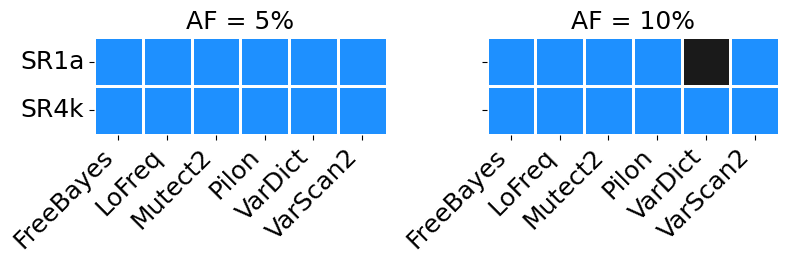

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

plot_freqs = [5, 10]

for freq_i in range(len(plot_freqs)):
    
    freq = plot_freqs[freq_i]
    
    df = heatmap_dfs[freq].pivot(index="tag", columns="tool", values="value")
    
    ax = axs[freq_i]

    ax.set_title("AF = {}%".format(freq), fontsize=18)
        
    sns.heatmap(data=df, square=True, vmin=0, vmax=1, cmap=sns.light_palette(blue), 
                linewidths=1, ax=ax, cbar=False)
    
    ax.tick_params(labelsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_linewidth(1.3)
    ax.spines['left'].set_linewidth(1.3)

    ax.tick_params(axis='x', labelrotation=45, labelsize=18) 
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontdict={"horizontalalignment": "right"})

    ax.tick_params(axis='y', labelrotation=0, labelsize=18)

    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.collections[0].cmap.set_bad('0.1')
    

plt.tight_layout()

file_name = "./figures/binosnp_data_analysis/rpob_recall_over5_heatmap.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/binosnp_data_analysis/rpob_recall_over5_heatmap.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

# rpoB FP AF distribution overall

In [75]:
rpoB_FP_AF.head()

,AF,tool
0,1.372213,FreeBayes
1,1.216545,FreeBayes
2,1.000000,Pilon
3,1.000000,Pilon
4,1.000000,Pilon


In [47]:
rpoB_FP_AF.loc[rpoB_FP_AF.shape[0]] = [np.nan, "LoFreq"]

In [76]:
tool_order = list(rpoB_FP_AF.tool.value_counts().sort_values().index)

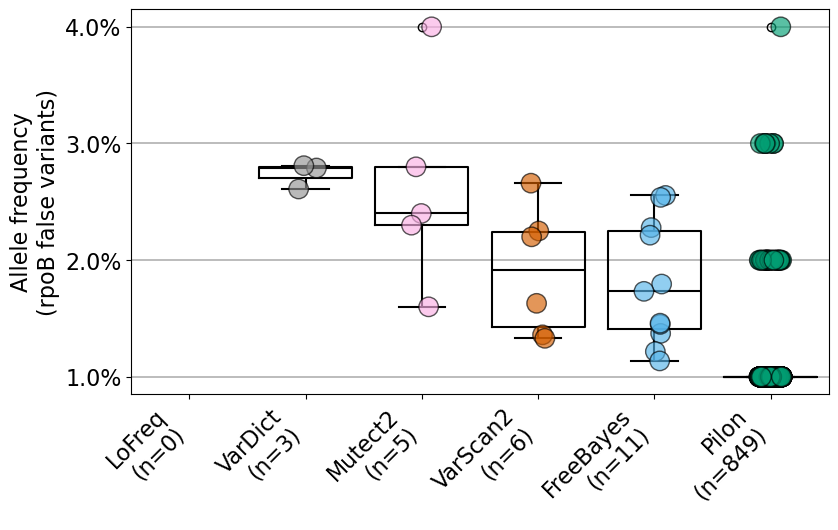

In [79]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.boxplot(data=rpoB_FP_AF, x="tool", y="AF", color="black",
           linewidth=1.5, ax=ax, fill=False, order=tool_order)

sns.stripplot(data=rpoB_FP_AF, x="tool", y="AF", hue="tool", palette=tool_colors_,
              size=14, edgecolor="black", linewidth=1, ax=ax, alpha=0.65, order=tool_order)

ax.tick_params(labelsize=16)

ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f%%'))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.set_yticks([1, 2, 3, 4])
ax.tick_params(labelsize=16)
ax.grid(axis="y", linewidth=1.2, zorder=1)
    
ax.set_xticks(ax.get_xticks())
tool_labels = list(tool_mapping.values()).copy()
tool_labels.sort()
ax.set_xticklabels(["{}\n(n={})".format(tool, rpoB_FP_AF[rpoB_FP_AF.tool == tool].dropna().shape[0]) for tool in tool_order], fontdict={"horizontalalignment": "right"})

ax.tick_params(axis="x", rotation=45, labelsize=16)

ax.set_xlabel("")
ax.set_ylabel("Allele frequency\n(rpoB false variants)", fontsize=16)

file_name = "./figures/binosnp_data_analysis/rpoB_FP_AF.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/binosnp_data_analysis/rpoB_FP_AF.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [78]:
pilon_rpoB_FP_AF = np.array(rpoB_FP_AF[rpoB_FP_AF.tool == "Pilon"]["AF"].values)
pilon_AF_min, pilon_AF_max = np.min(pilon_rpoB_FP_AF), np.max(pilon_rpoB_FP_AF)
num_pilon_FP_at_AF1 = sum(pilon_rpoB_FP_AF == 1)

print("Pilon rpoB FP at all AF")
print("min AF = {}, max AF = {}".format(pilon_AF_min, pilon_AF_max))
print("percentage of FP at AF = 1%: {}".format((num_pilon_FP_at_AF1/len(pilon_rpoB_FP_AF))*100))

Pilon rpoB FP at all AF
min AF = 1.0, max AF = 4.0
percentage of FP at AF = 1%: 95.0530035335689


# Number of rpoB FP overall

In [53]:
for tool in tools:

    tool_name = tool_mapping[tool]

    print(tool_name)

    tool_df = rpob_precision_recall_df[rpob_precision_recall_df.tool == tool_name]

    all_tag_num_FP = []
    for i in tool_df.index:

        tag = tool_df.loc[i, "tag"]
        num_FP = tool_df.loc[i, "num_FP"]
        all_tag_num_FP.append(num_FP)

        print(tag, num_FP)
    print("average num_FP = {}".format(np.nanmean(num_FP)))

    print()

FreeBayes
SR1a 2.0
SR4k 2.0
SR1a 2.0
SR4k 2.0
SR1a 2.0
SR4k 1.0
average num_FP = 1.0

LoFreq
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0
average num_FP = 0.0

Mutect2
SR1a 0.0
SR4k 2.0
SR1a 0.0
SR4k 2.0
SR1a 0.0
SR4k 1.0
average num_FP = 1.0

Pilon
SR1a 100.0
SR4k 180.0
SR1a 64.0
SR4k 290.0
SR1a 128.0
SR4k 87.0
average num_FP = 87.0

VarDict
SR1a 0.0
SR4k 1.0
SR1a 0.0
SR4k 1.0
SR1a nan
SR4k 1.0
average num_FP = 1.0

VarScan2
SR1a 1.0
SR4k 1.0
SR1a 1.0
SR4k 1.0
SR1a 1.0
SR4k 1.0
average num_FP = 1.0



# Number of rpoB FP at AF ≥ 5%

In [54]:
for tool in tools:

    tool_name = tool_mapping[tool]

    print(tool_name)

    tool_df = rpob_precision_recall_over5_df[rpob_precision_recall_over5_df.tool == tool_name]

    for i in tool_df.index:

        tag = tool_df.loc[i, "tag"]
        num_FP = tool_df.loc[i, "num_FP"]

        print(tag, num_FP)

    print()

FreeBayes
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0

LoFreq
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0

Mutect2
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0

Pilon
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0

VarDict
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0
SR1a nan
SR4k 0.0

VarScan2
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0
SR1a 0.0
SR4k 0.0



# Number of DR FP

## All AF

In [55]:
DR_num_FP_df.head()

,tag,freq,num_FP,tool
0,Mix-SR1a-rpoB531-1,0.01,5.0,FreeBayes
1,Mix-SR1a-rpoB531-1,0.01,0.0,LoFreq
2,Mix-SR1a-rpoB531-1,0.01,12.0,Mutect2
3,Mix-SR1a-rpoB531-1,0.01,1190.0,Pilon
4,Mix-SR1a-rpoB531-1,0.01,0.0,VarDict


In [56]:
for tool in tools:

    tool_name = tool_mapping[tool]

    print(tool_name)

    tool_df = DR_num_FP_df[DR_num_FP_df.tool == tool_name]

    for i in tool_df.index:

        tag = tool_df.loc[i, "tag"]
        num_FP = tool_df.loc[i, "num_FP"]

        print(tag, num_FP)

    print()

FreeBayes
Mix-SR1a-rpoB531-1 5.0
Mix-SR4k-rpoB526-1 19.0
Mix-SR1a-rpoB531-5 10.0
Mix-SR4k-rpoB526-5 21.0
Mix-SR1a-rpoB531-10 15.0
Mix-SR4k-rpoB526-10 7.0

LoFreq
Mix-SR1a-rpoB531-1 0.0
Mix-SR4k-rpoB526-1 3.0
Mix-SR1a-rpoB531-5 3.0
Mix-SR4k-rpoB526-5 0.0
Mix-SR1a-rpoB531-10 3.0
Mix-SR4k-rpoB526-10 4.0

Mutect2
Mix-SR1a-rpoB531-1 12.0
Mix-SR4k-rpoB526-1 9.0
Mix-SR1a-rpoB531-5 15.0
Mix-SR4k-rpoB526-5 5.0
Mix-SR1a-rpoB531-10 15.0
Mix-SR4k-rpoB526-10 14.0

Pilon
Mix-SR1a-rpoB531-1 1190.0
Mix-SR4k-rpoB526-1 2268.0
Mix-SR1a-rpoB531-5 962.0
Mix-SR4k-rpoB526-5 4227.0
Mix-SR1a-rpoB531-10 1505.0
Mix-SR4k-rpoB526-10 1309.0

VarDict
Mix-SR1a-rpoB531-1 0.0
Mix-SR4k-rpoB526-1 1.0
Mix-SR1a-rpoB531-5 2.0
Mix-SR4k-rpoB526-5 5.0
Mix-SR1a-rpoB531-10 nan
Mix-SR4k-rpoB526-10 1.0

VarScan2
Mix-SR1a-rpoB531-1 3.0
Mix-SR4k-rpoB526-1 4.0
Mix-SR1a-rpoB531-5 3.0
Mix-SR4k-rpoB526-5 1.0
Mix-SR1a-rpoB531-10 2.0
Mix-SR4k-rpoB526-10 1.0



## AF ≥ 5%

In [57]:
DR_num_FP_over5_df.head()

,tag,freq,num_FP,tool
0,Mix-SR1a-rpoB531-1,0.01,0.0,FreeBayes
1,Mix-SR1a-rpoB531-1,0.01,0.0,LoFreq
2,Mix-SR1a-rpoB531-1,0.01,0.0,Mutect2
3,Mix-SR1a-rpoB531-1,0.01,4.0,Pilon
4,Mix-SR1a-rpoB531-1,0.01,0.0,VarDict


In [58]:
for tool in tools:

    tool_name = tool_mapping[tool]

    print(tool_name)

    tool_df = DR_num_FP_over5_df[DR_num_FP_over5_df.tool == tool_name]

    for i in tool_df.index:

        tag = tool_df.loc[i, "tag"]
        num_FP = tool_df.loc[i, "num_FP"]

        print(tag, num_FP)

    print()

FreeBayes
Mix-SR1a-rpoB531-1 0.0
Mix-SR4k-rpoB526-1 0.0
Mix-SR1a-rpoB531-5 0.0
Mix-SR4k-rpoB526-5 0.0
Mix-SR1a-rpoB531-10 0.0
Mix-SR4k-rpoB526-10 0.0

LoFreq
Mix-SR1a-rpoB531-1 0.0
Mix-SR4k-rpoB526-1 0.0
Mix-SR1a-rpoB531-5 0.0
Mix-SR4k-rpoB526-5 0.0
Mix-SR1a-rpoB531-10 2.0
Mix-SR4k-rpoB526-10 1.0

Mutect2
Mix-SR1a-rpoB531-1 0.0
Mix-SR4k-rpoB526-1 0.0
Mix-SR1a-rpoB531-5 0.0
Mix-SR4k-rpoB526-5 0.0
Mix-SR1a-rpoB531-10 0.0
Mix-SR4k-rpoB526-10 0.0

Pilon
Mix-SR1a-rpoB531-1 4.0
Mix-SR4k-rpoB526-1 8.0
Mix-SR1a-rpoB531-5 7.0
Mix-SR4k-rpoB526-5 11.0
Mix-SR1a-rpoB531-10 8.0
Mix-SR4k-rpoB526-10 4.0

VarDict
Mix-SR1a-rpoB531-1 0.0
Mix-SR4k-rpoB526-1 0.0
Mix-SR1a-rpoB531-5 0.0
Mix-SR4k-rpoB526-5 0.0
Mix-SR1a-rpoB531-10 nan
Mix-SR4k-rpoB526-10 0.0

VarScan2
Mix-SR1a-rpoB531-1 0.0
Mix-SR4k-rpoB526-1 0.0
Mix-SR1a-rpoB531-5 0.0
Mix-SR4k-rpoB526-5 0.0
Mix-SR1a-rpoB531-10 0.0
Mix-SR4k-rpoB526-10 0.0



# AF ≥ 5% distribution of DR FP

In [59]:
DR_FP_AF_over5.head()

,AF,tool
0,7.0,Pilon
1,5.0,Pilon
2,5.0,Pilon
3,11.0,Pilon
4,7.0,Pilon


In [80]:
order_df = pd.DataFrame(columns=["tool", "num_FP"])
df_i = 0
for tool in tools:
    tool_df = DR_FP_AF_over5[DR_FP_AF_over5.tool == tool_mapping[tool]]
    num_FP = tool_df.shape[0]
    order_df.loc[df_i] = [tool_mapping[tool], num_FP]
    df_i += 1
order_df.sort_values(["num_FP", "tool"], inplace=True, ascending=True)
tool_order = order_df.tool.values
order_df

,tool,num_FP
0,FreeBayes,0
2,Mutect2,0
4,VarDict,0
5,VarScan2,0
1,LoFreq,3
3,Pilon,42


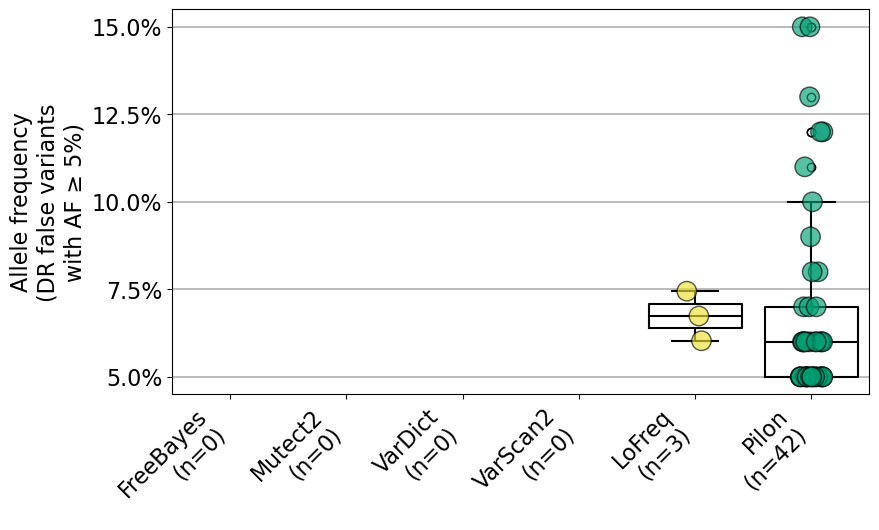

In [81]:
fig, ax = plt.subplots(figsize=(9, 5))

sns.boxplot(data=DR_FP_AF_over5, x="tool", y="AF", color="black",
           linewidth=1.5, ax=ax, fill=False, order=tool_order)

sns.stripplot(data=DR_FP_AF_over5, x="tool", y="AF", hue="tool", palette=tool_colors_,
              size=14, edgecolor="black", linewidth=1, ax=ax, alpha=0.65, order=tool_order)

ax.tick_params(labelsize=16)

ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f%%'))
ax.yaxis.set_major_locator(MultipleLocator(2.5))
ax.tick_params(labelsize=16)
ax.grid(axis="y", linewidth=1.2, zorder=1)
    
ax.set_xticks(ax.get_xticks())
tool_labels = list(tool_mapping.values()).copy()
tool_labels.sort()
ax.set_xticklabels(["{}\n(n={})".format(tool, DR_FP_AF_over5[DR_FP_AF_over5.tool == tool].dropna().shape[0]) for tool in tool_order], fontdict={"horizontalalignment": "right"})

ax.tick_params(axis="x", rotation=45, labelsize=16)

ax.set_xlabel("")
ax.set_ylabel("Allele frequency\n(DR false variants\nwith AF ≥ 5%)", fontsize=16)

file_name = "./figures/binosnp_data_analysis/DR_FP_AF5andOver.pdf"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

file_name = "./figures/binosnp_data_analysis/DR_FP_AF5andOver.jpeg"
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [67]:
DR_FP_AF_over5[DR_FP_AF_over5.tool == "LoFreq"]["AF"].max()

7.4468

In [64]:
DR_FP_AF_over5[DR_FP_AF_over5.tool == "Pilon"]["AF"].min(), DR_FP_AF_over5[DR_FP_AF_over5.tool == "Pilon"]["AF"].max()

(5.0, 15.0)